In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
import tempfile
from PIL import Image
import numpy as np
import gc
import pandas as pd

from skimage.metrics import structural_similarity as ssim
import seaborn as sns
import numpy as np

import time

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import numpy as np
import gc
import sys
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict


## **Face Extraction: Orginal Videos**

Note: Using OpenCV & SSIM from SKlearn, These sometimes fetch some blank frame without faces, we need to manually checkup & remove those for further process. in 5fps

In [ ]:
def og_video_to_face(df,start_index = 0,end_index=1000,video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/original_sequences/youtube/c23/videos/', destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/',fps=5):
  video_files = sorted([f for f in os.listdir(video_folder_path) if os.path.isfile(video_folder_path + f)])[start_index:end_index]

  face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  #df = pd.DataFrame(columns = ['file','image_index','x','y','x+w','y+h'])

  df_index = 0

  for video in video_files:
    cap = cv2.VideoCapture(video_folder_path+video)
    frame_intervals = int(cap.get(cv2.CAP_PROP_FPS)/fps)

    print(video)

    frame_indices = range(0,int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),frame_intervals)
    img_index = 0

    os.makedirs(destination_path+video[:-4], exist_ok=True)

    for i in frame_indices:
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()

      gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      faces = face_classifier.detectMultiScale(gray_image, minNeighbors=5, minSize=(20, 20))
      if len(faces) != 0:
        x,y,w,h = faces[0]
        face = cv2.resize(frame[y:y+h,x:x+w], (256, 256))

        wp = destination_path+video[:-4]+'/'+f'{img_index:05}'+'.png'
        cv2.imwrite(wp, face)

        df.loc[df_index] = [video[:-4],f'{img_index:05}',x,y,x+w,y+h]
      else:
        df.loc[df_index] = [video[:-4],f'{img_index:05}',0,0,0,0]

      img_index+=1
      df_index+=1

  return df

In [ ]:
# box_df creating with function call & time tracking...

st=time.time()
box_df = pd.DataFrame(columns = ['file','image_index','x','y','x+w','y+h'])
box_df['file'] = box_df['file'].astype(str)
og_video_to_face(box_df,225,226)
print(time.time()-st)

225.mp4
55.08326244354248


In [ ]:
box_df = pd.read_csv('/content/drive/MyDrive/DeepFake Detection/extracted_frames/face_box.csv')

# box_df.to_csv('/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/face_box_225.csv',index = False)

## - - - Important!!! Make Sure to delete non-face images - - -

# Join CSV

In [ ]:
# Path to your directory
csv_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/'

# List all files in the directory
all_files = os.listdir(csv_path)

# Filter out CSV files
csv_files = [file for file in all_files if file.endswith('.csv')]

# Define a function to extract the starting number from the file name
def extract_number(file_name):
    # Remove prefix and extension, then split by '-'
    parts = file_name.replace("face_box_", "").replace(".csv", "").split("-")
    # Convert the first part to an integer
    return int(parts[0])

# Sort files by the extracted number
sorted_files = sorted(csv_files, key=extract_number)

# Print sorted files
# for file in sorted_files:
#     print(file)

print(sorted_files)

['face_box_0.csv', 'face_box_1-49.csv', 'face_box_50.csv', 'face_box_51-99.csv', 'face_box_100.csv', 'face_box_101-149.csv', 'face_box_150.csv', 'face_box_151-199.csv', 'face_box_200.csv', 'face_box_201-224.csv', 'face_box_225.csv', 'face_box_226-249.csv', 'face_box_250.csv', 'face_box_251-299.csv', 'face_box_300.csv', 'face_box_301-349.csv', 'face_box_350.csv', 'face_box_351-399.csv', 'face_box_400-449.csv', 'face_box_450.csv', 'face_box_451-499.csv', 'face_box_500.csv', 'face_box_501-549.csv', 'face_box_550.csv', 'face_box_551-599.csv', 'face_box_600.csv', 'face_box_601-649.csv', 'face_box_650.csv', 'face_box_651-699.csv', 'face_box_700.csv', 'face_box_701-749.csv', 'face_box_750.csv', 'face_box_751-799.csv', 'face_box_800.csv', 'face_box_801-849.csv', 'face_box_850.csv', 'face_box_851-899.csv', 'face_box_900.csv', 'face_box_901-949.csv', 'face_box_950.csv', 'face_box_951-999.csv']


In [ ]:
# Initialize an empty DataFrame to hold the concatenated data
concatenated_df = pd.DataFrame()

# Read and concatenate each file
for file in sorted_files:
    file_path = csv_path + file
    df = pd.read_csv(file_path)
    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)

# Save the concatenated DataFrame as a new CSV file
output_file = csv_path + 'concatenated_file.csv'
concatenated_df.to_csv(output_file, index=False)

print("Concatenated file saved as 'concatenated_file.csv'")

Concatenated file saved as 'concatenated_file.csv'


# Face Extraction: Manupulated Videos

In [ ]:
def fake_video_to_face(df,video_folder_path, destination_path, fps=5):
  video_files = sorted([f for f in os.listdir(video_folder_path) if os.path.isfile(video_folder_path + f)])
  print(video_files)

  for video in video_files:
    cap = cv2.VideoCapture(video_folder_path+video)

    og_video = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/' + video[:video.find('_')]+'/'
    og_video_frames = sorted([int(f[:-4]) for f in os.listdir(og_video) if os.path.isfile(og_video + f)])
    # print(og_video_frames)

    t = df[df['file']==int(video[:video.find('_')])]
    t = t[t['image_index'].isin(og_video_frames)]

    print(video)

    os.makedirs(destination_path+video[:-4], exist_ok=True)

    for _, i in t.iterrows():
      cap.set(cv2.CAP_PROP_POS_FRAMES, i['image_index'])
      ret, frame = cap.read()

      x,y,xw,yh = i[['x','y','x+w','y+h']]

      face = cv2.resize(frame[y:yh,x:xw], (256, 256))

      wp = destination_path+video[:-4]+'/'+f'{i.image_index:05}'+'.png'
      cv2.imwrite(wp, face)

In [ ]:
box_df = pd.read_csv('/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/concatenated_file.csv')


In [ ]:
# For DeepFake Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Deepfakes/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Deepfakes/'
  )


['000_003.mp4', '001_870.mp4', '002_006.mp4', '003_000.mp4', '004_982.mp4', '005_010.mp4', '006_002.mp4', '007_132.mp4', '008_990.mp4', '009_027.mp4', '010_005.mp4', '011_805.mp4', '012_026.mp4', '013_883.mp4', '014_790.mp4', '015_919.mp4', '016_209.mp4', '017_803.mp4', '018_019.mp4', '019_018.mp4', '020_344.mp4', '021_312.mp4', '022_489.mp4', '023_923.mp4', '024_073.mp4', '025_067.mp4', '026_012.mp4', '027_009.mp4', '028_068.mp4', '029_048.mp4', '030_193.mp4', '031_163.mp4', '032_944.mp4', '033_097.mp4', '034_590.mp4', '035_036.mp4', '036_035.mp4', '037_072.mp4', '038_125.mp4', '039_058.mp4', '040_997.mp4', '041_063.mp4', '042_084.mp4', '043_110.mp4', '044_945.mp4', '045_889.mp4', '046_904.mp4', '047_862.mp4', '048_029.mp4', '049_946.mp4', '050_059.mp4', '051_332.mp4', '052_108.mp4', '053_095.mp4', '054_071.mp4', '055_147.mp4', '056_996.mp4', '057_070.mp4', '058_039.mp4', '059_050.mp4', '060_088.mp4', '061_080.mp4', '062_066.mp4', '063_041.mp4', '064_991.mp4', '065_089.mp4', '066_062.

In [ ]:
# For Face2Face Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Face2Face/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Face2Face/'
  )


In [ ]:
# For FaceShifter Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/FaceShifter/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/FaceShifter/'
  )


In [ ]:
# For FaceSwap Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/FaceSwap/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/FaceSwap/'
  )


['000_003.mp4', '001_870.mp4', '002_006.mp4', '003_000.mp4', '004_982.mp4', '005_010.mp4', '006_002.mp4', '007_132.mp4', '008_990.mp4', '009_027.mp4', '010_005.mp4', '011_805.mp4', '012_026.mp4', '013_883.mp4', '014_790.mp4', '015_919.mp4', '016_209.mp4', '017_803.mp4', '018_019.mp4', '019_018.mp4', '020_344.mp4', '021_312.mp4', '022_489.mp4', '023_923.mp4', '024_073.mp4', '025_067.mp4', '026_012.mp4', '027_009.mp4', '028_068.mp4', '029_048.mp4', '030_193.mp4', '031_163.mp4', '032_944.mp4', '033_097.mp4', '034_590.mp4', '035_036.mp4', '036_035.mp4', '037_072.mp4', '038_125.mp4', '039_058.mp4', '040_997.mp4', '041_063.mp4', '042_084.mp4', '043_110.mp4', '044_945.mp4', '045_889.mp4', '046_904.mp4', '047_862.mp4', '048_029.mp4', '049_946.mp4', '050_059.mp4', '051_332.mp4', '052_108.mp4', '053_095.mp4', '054_071.mp4', '055_147.mp4', '056_996.mp4', '057_070.mp4', '058_039.mp4', '059_050.mp4', '060_088.mp4', '061_080.mp4', '062_066.mp4', '063_041.mp4', '064_991.mp4', '065_089.mp4', '066_062.

In [ ]:
# For NeuralTextures Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/NeuralTextures/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/NeuralTextures/'
  )


# Generating Mask

In [ ]:
'''
# Common
og_video_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/DeepFake/'


# Method 1
src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Deepfakes/'


# Method 2
df = pd.read_csv('/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/concatenated_file.csv')
og_video_folder_path = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/original_sequences/youtube/c23/videos/'
src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Deepfakes/c23/videos/'

# Extra
faces = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/'
'''


## Method 1: Fast but not so good at perfect mask generating

I will use method 2 not 1

In [ ]:
def mask_generation_1(og_video_path, des_path, src_path):
  videos = sorted([f for f in os.listdir(src_path) if os.path.isdir(src_path+f)])
  for video in videos:
    frames = [f for f in os.listdir(src_path+video)]
    os.makedirs(des_path+video, exist_ok=True)
    print(video)

    for frame in frames:
      df_image = cv2.imread(src_path+video+'/'+frame, cv2.IMREAD_GRAYSCALE)
      og_image = cv2.imread(og_video_path+video[:3]+'/'+frame, cv2.IMREAD_GRAYSCALE)
      _,sim = ssim(df_image, og_image,full=True)

      sim = 1-sim
      sim[sim<=0.2] = 0
      sim*=255
      mask = np.zeros((258,258))
      mask[1:257,1:257] = sim

      wp = des_path+video+'/'+frame
      cv2.imwrite(wp, mask)

  return


In [ ]:
# Common
og_video_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/'


In [ ]:
# Deepfake
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Deepfakes/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/DeepFake/'
mask_generation_1(og_video_path, des_path, src_path)


In [ ]:
# Face2Face
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Face2Face/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/Face2Face/'
mask_generation_1(og_video_path, des_path, src_path)


In [ ]:
# FaceShifter
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/FaceShifter/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/FaceShifter/'
mask_generation_1(og_video_path, des_path, src_path)


In [ ]:
# FaceSwap
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/FaceSwap/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/FaceSwap/'
mask_generation_1(og_video_path, des_path, src_path)


In [ ]:
# NeuralTextures
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/NeuralTextures/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/NeuralTextures/'
mask_generation_1(og_video_path, des_path, src_path)


## Method 2: Slow But good enough to produce great masks

In [ ]:
def mask_generation_2(df, og_video_path, og_video_folder_path, des_path, src_videos):
    videos = sorted([f for f in os.listdir(src_videos) if os.path.isfile(src_videos+f)])
    for video in videos:
        print(video)

        frames = [f for f in os.listdir(og_video_path+video[:3])]
        cap_og = cv2.VideoCapture(og_video_folder_path+video[:3]+'.mp4')
        cap_d = cv2.VideoCapture(src_videos+video)

        t = df[df['file'] == int(video[:3])]
        os.makedirs(des_path+video[:-4], exist_ok=True)

        for frame in frames:
            frame_index = int(frame[:-4])
            cap_og.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            cap_d.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            _, frame_og = cap_og.read()
            _, frame_d = cap_d.read()
            tt = t[t['image_index'] == frame_index][['x','y','x+w','y+h']]
            x,y,xw,yh = tt.values[0][0],tt.values[0][1],tt.values[0][2],tt.values[0][3]

            og = cv2.cvtColor(frame_og, cv2.COLOR_BGR2GRAY)
            d = cv2.cvtColor(frame_d, cv2.COLOR_BGR2GRAY)

            _,sim = ssim(og[y:yh,x:xw],d[y:yh,x:xw],full=True)
            sim = 1-sim
            sim[sim<=0.2] = 0
            sim*=255
            mask = np.zeros((258,258))
            mask[1:257,1:257] = cv2.resize(sim,(256,256))

            wp = des_path+video[:-4]+'/'+frame[:-4]+'.png'
            cv2.imwrite(wp, mask)
    return


In [ ]:
# Common
og_video_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/'
df = pd.read_csv('/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/concatenated_file.csv')
og_video_folder_path = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/original_sequences/youtube/c23/videos/'


In [ ]:
# Deepfake
deepfake_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/Deepfakes/'
deepfake_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Deepfakes/c23/videos/'
mask_generation_2(df, og_video_path, og_video_folder_path, des_path=deepfake_des_path, src_videos=deepfake_src_videos)


999_960.mp4


In [ ]:
# Face2Face
Face2Face_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Face2Face/c23/videos/'
Face2Face_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/Face2Face/'

mask_generation_2(df, og_video_path, og_video_folder_path, des_path=Face2Face_des_path, src_videos=Face2Face_src_videos)


In [ ]:
# FaceShifter
FaceShifter_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/FaceShifter/c23/videos/'
FaceShifter_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/FaceShifter/'

mask_generation_2(df, og_video_path, og_video_folder_path, des_path=FaceShifter_des_path, src_videos=FaceShifter_src_videos)


In [ ]:
# FaceSwap
FaceSwap_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/FaceSwap/c23/videos/'
FaceSwap_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/FaceSwap/'

mask_generation_2(df, og_video_path, og_video_folder_path, des_path=FaceSwap_des_path, src_videos=FaceSwap_src_videos)


In [ ]:
# NeuralTextures
NeuralTextures_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/NeuralTextures/c23/videos/'
NeuralTextures_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/NeuralTextures/'

mask_generation_2(df, og_video_path, og_video_folder_path, des_path=NeuralTextures_des_path, src_videos=NeuralTextures_src_videos)


602_397.mp4
603_575.mp4
604_703.mp4
605_591.mp4
606_567.mp4
607_683.mp4
608_675.mp4
609_596.mp4
610_692.mp4
611_760.mp4
612_702.mp4
613_685.mp4
614_616.mp4
615_687.mp4
616_614.mp4
617_566.mp4
618_629.mp4
619_620.mp4
620_619.mp4
621_546.mp4
622_647.mp4
623_630.mp4
624_570.mp4
625_650.mp4
626_562.mp4
627_658.mp4
628_568.mp4
629_618.mp4
630_623.mp4
631_551.mp4
632_548.mp4
633_529.mp4
634_660.mp4
635_642.mp4
636_578.mp4
637_427.mp4
638_640.mp4
639_841.mp4
640_638.mp4
641_662.mp4
642_635.mp4
643_646.mp4
644_657.mp4
645_688.mp4
646_643.mp4
647_622.mp4
648_654.mp4
649_816.mp4
650_625.mp4
651_835.mp4
652_773.mp4
653_601.mp4
654_648.mp4
655_444.mp4
656_666.mp4
657_644.mp4
658_627.mp4
659_749.mp4
660_634.mp4
661_670.mp4
662_641.mp4
663_231.mp4
664_668.mp4
665_679.mp4
666_656.mp4
667_446.mp4
668_664.mp4
669_682.mp4
670_661.mp4
671_677.mp4
672_720.mp4
673_728.mp4
674_744.mp4
675_608.mp4
676_776.mp4
677_671.mp4
678_460.mp4
679_665.mp4
680_486.mp4
681_711.mp4
682_669.mp4
683_607.mp4
684_717.mp4
685_

# Look Up Table Generation


In [ ]:
def sample_df(path,frame_count,index,video_index,video_title,vtype,label,df):
  num_of_frames = len(os.listdir(path))
  sample_count = (num_of_frames+frame_count-1)//frame_count

  for i in range(sample_count):
    current_fc = min(frame_count, num_of_frames - i*frame_count)
    df.loc[index+i] = [index+i, video_index, video_title, vtype, label, i, current_fc]
  return index+sample_count


def type_sample_df(path,frame_count,index,video_index,vtype,label,df):
  folders = sorted([f for f in os.listdir(path) if os.path.isdir(path+'/'+f)])
  for i in range(len(folders)):
    index = sample_df(path+'/'+folders[i],frame_count,index,video_index+i,folders[i],vtype,label,df)
  return index, video_index+len(folders)


def all_sample_df(path,frame_count):
  df = pd.DataFrame(columns = ['sample_index','video_index','video_title','video_type','type_label', 'part_num','part_frames'])
  folders = sorted([f for f in os.listdir(path) if os.path.isdir(path+f)])
  index, video_index = 0, 0
  for i in range(len(folders)):
    index, video_index = type_sample_df(path+folders[i],frame_count,index,video_index,i,folders[i],df)
  return df



In [ ]:
extracted_frames_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/'

In [ ]:
# Generate Look-up if not exist
# lookup_tabel = all_sample_df(path= extracted_frames_path, frame_count=20)
# lookup_tabel.to_csv(extracted_frames_path + 'lookup_table.csv', index=False)  # Set index=False if you don't want to save row indices


In [ ]:
# Load Look-up if already exist
lookup_tabel = pd.read_csv(extracted_frames_path + 'lookup_table.csv')


In [ ]:
lookup_tabel.tail()


,sample_index,video_index,video_title,video_type,type_label,part_num,part_frames
24806,24806,5439,998,5,og_videos,1,20
24807,24807,5439,998,5,og_videos,2,16
24808,24808,5440,999,5,og_videos,0,20
24809,24809,5440,999,5,og_videos,1,20
24810,24810,5440,999,5,og_videos,2,9


In [ ]:
def sample_by_index(sample_index,frame_count,look_up_table,path,path_mask):
  t = look_up_table.iloc[sample_index]

  path += t.type_label +'/'+ t.video_title
  #  path_mask += t.type_label +'/'+ t.video_title

  frame_names = sorted([f for f in os.listdir(path)])

  imgs = np.zeros((frame_count,256,256,3),dtype=np.uint8)
  #masks = np.zeros((258,258,frame_count),dtype=np.float32)

  for i in range(t.part_frames):
    img = Image.open(path+'/'+frame_names[t.part_num*frame_count+i])
    imgs[i,:,:,:] = np.array(img)
    # if(t.type_label != 'og_videos'):
    #   mask = Image.open(path_mask+'/'+frame_names[t.part_num*frame_count+i])
    #   masks[:,:,i] = np.array(mask)

  label = np.zeros(6,dtype=np.uint8)
  label[t.video_type] = 1
  return imgs, label



In [ ]:
def sample_gen(indices,frame_count,look_up_table,path,path_mask):
  for i in indices:
    yield sample_by_index(i, frame_count, look_up_table, path, path_mask)


# Train Test Split

In [ ]:
video_train_indices, video_test_indices = train_test_split(range(5441), test_size = 0.2, random_state=10)

train_lookup_table = lookup_tabel[lookup_tabel.video_index.isin(video_train_indices)]
test_lookup_table = lookup_tabel[lookup_tabel.video_index.isin(video_test_indices)]

train_indices = train_lookup_table[train_lookup_table['part_frames'] == 20]['sample_index'].tolist()
train_indices = shuffle(train_indices, random_state=50)

test_indices = test_lookup_table[test_lookup_table['part_frames'] == 20]['sample_index'].tolist()


In [ ]:
len(test_indices)


3940

In [ ]:
x = lookup_tabel[lookup_tabel.sample_index.isin(test_indices)]

for i in range(6):
    print(x[x['video_type'] == i]['type_label'].iloc[0], ' = ', len(x[x['video_type'] == i]))


Deepfakes  =  538
Face2Face  =  686
FaceShifter  =  501
FaceSwap  =  697
NeuralTextures  =  806
og_videos  =  712


In [ ]:
extracted_frames_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/'
mask_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/'
fc = 20


In [ ]:
len(train_indices)

15810

In [ ]:
start_of_train_sample = 0
end_of_train_sample = 160

dataset = tf.data.Dataset.from_generator(
    lambda: sample_gen(train_indices[start_of_train_sample : end_of_train_sample], fc, lookup_tabel, extracted_frames_path, mask_path),
    output_signature=(
        tf.TensorSpec(shape=(fc, 256, 256, 3), dtype=tf.float32),  # Corrected shape for images
        tf.TensorSpec(shape=(6,), dtype=tf.float32)  # Assuming 'label' is a one-hot encoded vector of length 6
    )
)


# Image into Numpy Array: save in drive

In [ ]:
# Define the shape and data type
shape = (15810, 20, 256, 256, 3)  # total shape of train sample
label = np.zeros((15810, 6), dtype=np.uint8)

# Calculate the number of bytes needed
total_bytes = np.prod(shape) * np.dtype(np.uint8).itemsize
print(f"Total space needed: {total_bytes/1024/1024/1024} GB")


Total space needed: 57.89794921875 GB


In [ ]:
train_sample_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/sample.npy'
train_label_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/label.npy'


In [ ]:
# ================ !!! Caution !!! =====================
'''
# Ensure the directory exists
os.makedirs(os.path.dirname(train_sample_path), exist_ok=True)

# Open or create the file and ensure it is the correct size
with open(train_sample_path, 'wb') as f:
    f.seek(total_bytes - 1)
    f.write(b'\0')  # This expands the file to the correct size with zero initialization

'''


In [ ]:
# Memory map the file
train_memory_map = np.memmap(train_sample_path, dtype=np.uint8, mode='r+', shape=shape)
label = np.load(train_label_path)


In [ ]:
j = 14000
for i in train_indices[14000:]:
    train_memory_map[j], label[j] = sample_by_index(i, fc, lookup_tabel, extracted_frames_path, mask_path)
    j += 1
    print(j)

train_memory_map.flush()
del train_memory_map

np.save(train_label_path, label)


In [ ]:
for i in range(14000, 15810):
    if np.sum(train_memory_map[i]) == 0:
        print('train_memory_map = ', i)
        break
    if np.sum(label[i]) == 0:
        print('label = ', i)
        break

    print(i)


In [ ]:
sample_by_index(train_indices[14100], fc, lookup_tabel, extracted_frames_path, mask_path)


# Memory Map to Numpy Array

In [ ]:
shape = (15810, 20, 256, 256, 3)
train_sample_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/sample.npy'

sample = np.memmap(train_sample_path, dtype=np.uint8, mode='r', shape=shape)




In [ ]:
array_sample = np.array(sample)


In [ ]:
sample_array_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/sample_array.npy'
np.save(sample_array_path, array_sample)



# Load Memory Map for Training & Testing

In [ ]:
sample_array_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/sample_array.npy'
train_label_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/label.npy'

sample = np.load(sample_array_path, mmap_mode='r')
label = np.load(train_label_path)

# Testing
test_sample_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/test_sample.npy'
test_label_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/test_label.npy'

test_sample = np.load(test_sample_path, mmap_mode='r')
test_label = np.load(test_label_path)


In [ ]:
# 0 = Deepfakes
# 1 = Face2Face
# 2 = FaceShifter
# 3 = FaceSwap
# 4 = NeuralTextures
# 5 = og_videos

# Indices without neural texture
Train_indices = np.where(np.argmax(label, axis=1) != 4)[0]
Test_indices = np.where(np.argmax(test_label, axis=1) != 4)[0]



# Model Architecture

In [ ]:
class my_Conv3d(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0, bias=False):
    super(my_Conv3d, self).__init__()

    self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
    self.norm = nn.BatchNorm3d(out_ch)
    self.relu = nn.ReLU(inplace = True)

  def forward(self,x):
    return self.relu(self.norm(self.conv(x)))

class inception_block_norm(nn.Module):
  def __init__(self, in_ch, filters):
    super(inception_block_norm, self).__init__()

    self.conv1_direct = my_Conv3d(in_ch, filters[0], kernel_size=1)

    self.conv1_3 = my_Conv3d(in_ch, filters[1], kernel_size=1)
    self.conv3 = my_Conv3d(filters[1], filters[2], kernel_size=3, padding=1)

    self.conv1_5 = my_Conv3d(in_ch, filters[3], kernel_size=1)
    self.conv5 = my_Conv3d(filters[3], filters[4], kernel_size=5, padding=2)

    self.pool = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)
    self.conv1_after_pool = my_Conv3d(in_ch, filters[5], kernel_size=1)

  def forward(self, x):
    direct = self.conv1_direct(x)

    out3 = self.conv3(self.conv1_3(x))
    out5 = self.conv5(self.conv1_5(x))

    pool_conv = self.conv1_after_pool(self.pool(x))

    out = torch.cat([direct, out3, out5, pool_conv], dim=1)

    return out

class inception_net_norm(nn.Module):
  def __init__(self, in_ch=3):
    super(inception_net_norm, self).__init__()

    self.conv7_0 = my_Conv3d(in_ch, 64, kernel_size=7, stride=2, padding=3)
    self.conv1_0 = my_Conv3d(64, 64, kernel_size=1, stride=1, padding=0)
    self.conv3_0 = my_Conv3d(64, 192, kernel_size=3, stride=1, padding=1)

    self.ib_3a = inception_block_norm(192,[64,96,128,16,32,32])
    self.ib_3b = inception_block_norm(256,[128,128,192,32,96,64])

    self.ib_4a = inception_block_norm(480,[192,96,208,16,48,64])
    self.ib_4b = inception_block_norm(512,[160,112,224,24,64,64])
    self.ib_4c = inception_block_norm(512,[128,128,256,24,64,64])
    self.ib_4d = inception_block_norm(512,[112,144,288,32,64,64])
    self.ib_4e = inception_block_norm(528,[256,160,320,32,128,128]) # out_ch 832

    self.ib_5a = inception_block_norm(832,[256,160,320,32,128,128])
    self.ib_5b = inception_block_norm(832,[384,192,384,48,128,128]) #out ch 1024

    self.avg_pool = nn.AvgPool3d(kernel_size = (1,8,8), stride = 1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, 5)

    self.pool= nn.MaxPool3d(kernel_size=3, stride = 2, padding=1)

  def forward(self, x):
    x = self.pool(self.conv7_0(x))
    x = self.conv1_0(x)
    x = self.pool(self.conv3_0(x))

    x = self.ib_3b(self.ib_3a(x))
    x = self.pool(x)

    x = self.ib_4b(self.ib_4a(x))
    x = self.ib_4e(self.ib_4d(self.ib_4c(x)))
    x = self.pool(x)

    x = self.ib_5b(self.ib_5a(x))
    x = self.avg_pool(x)

    x = self.dropout(x)
    x = self.fc1(x.view(-1, 1024))

    return x


In [ ]:
my = inception_net_norm()


In [ ]:
'''
def remove_neuron(model, neuron_index):
    # Extract the final layer
    final_layer = model.fc1

    # Get the weights and biases
    weight = final_layer.weight.data
    bias = final_layer.bias.data

    # Remove the neuron (column in weights, element in bias)
    new_weight = torch.cat((weight[:neuron_index], weight[neuron_index+1:]), dim=0)
    new_bias = torch.cat((bias[:neuron_index], bias[neuron_index+1:]), dim=0)

    # Create a new final layer with the modified weights and biases
    new_final_layer = nn.Linear(final_layer.in_features, final_layer.out_features - 1)
    new_final_layer.weight = nn.Parameter(new_weight)
    new_final_layer.bias = nn.Parameter(new_bias)

    # Replace the original final layer with the new layer in the model
    model.fc1 = new_final_layer

# Remove the neuron at index 4 from the last layer: Neural Texture
remove_neuron(my, 4)

# Print the modified model
# print(my)
'''

In [ ]:
# my = inception_net_norm()

model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v14(Inception)/my1.pth'
my.load_state_dict(torch.load(model_path))


<All keys matched successfully>

## Visulize Model Architecture

In [ ]:
from torchsummary import summary
summary(my, (3, 20, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 10, 128, 128]          65,856
       BatchNorm3d-2     [-1, 64, 10, 128, 128]             128
              ReLU-3     [-1, 64, 10, 128, 128]               0
         my_Conv3d-4     [-1, 64, 10, 128, 128]               0
         MaxPool3d-5        [-1, 64, 5, 64, 64]               0
            Conv3d-6        [-1, 64, 5, 64, 64]           4,096
       BatchNorm3d-7        [-1, 64, 5, 64, 64]             128
              ReLU-8        [-1, 64, 5, 64, 64]               0
         my_Conv3d-9        [-1, 64, 5, 64, 64]               0
           Conv3d-10       [-1, 192, 5, 64, 64]         331,776
      BatchNorm3d-11       [-1, 192, 5, 64, 64]             384
             ReLU-12       [-1, 192, 5, 64, 64]               0
        my_Conv3d-13       [-1, 192, 5, 64, 64]               0
        MaxPool3d-14       [-1, 192, 3,


# Training Setup

In [ ]:
class my_Dataset(Dataset):
    def __init__(self, samples, labels, indices=None, transform=None):
        self.samples = samples
        self.indices = indices
        self.labels =  np.where(np.argmax(labels,axis=1) == 5, 4, np.argmax(labels,axis=1))
        self.transform = transform

    def __len__(self):
        if self.indices is None:
            return self.samples.shape[0]
        return self.indices.shape[0]

    def __getitem__(self, idx):
        if self.indices is None:
            sample = torch.from_numpy(np.copy(self.samples[idx])).permute(3, 0, 1, 2).float()/255.0
            label = self.labels[idx]
            return sample, label

        sample = torch.from_numpy(np.copy(self.samples[self.indices[idx]])).permute(3, 0, 1, 2).float()/255.0
        label = self.labels[self.indices[idx]]

        return sample, label


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my = my.to(device)


In [ ]:
my_optimizer = optim.Adam(my.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()


In [ ]:
# Validaition set: from test data
# train_index_start = 0
# train_index_end = 2000

train_dataset = my_Dataset(sample, label, Train_indices)
train_data = DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=0)

test_dataset = my_Dataset(test_sample, test_label, Test_indices)
test_data = DataLoader(test_dataset, batch_size=36, shuffle=True, num_workers=0)

validation_data = test_data


In [ ]:
print("Training Data: ", len(Train_indices))
print("Validation Data: ", len(Test_indices))
print("Testing Data: ", len(Test_indices))


Training Data:  12939
Validation Data:  3134
Testing Data:  3134


In [ ]:
torch.cuda.empty_cache()


In [ ]:
gc.collect()


0

# Training Loop

In [ ]:
num_epochs = 2
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    se = time.time()
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%1 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/2 Val_Loss: 0.706681 Val_Accuracy: 0.85578
Epoch   1/2 Loss: 0.012814 Accuracy: 0.99498 epoch_time: 1780.24s
Epoch   2/2 Val_Loss: 0.703218 Val_Accuracy: 0.85609
Epoch   2/2 Loss: 0.010656 Accuracy: 0.99606 epoch_time: 1783.51s


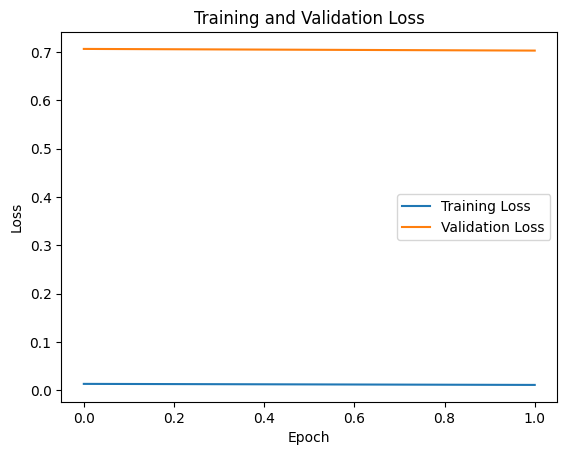

In [ ]:
# epochs = range(1, len(train_losses) + 1)  # Epochs for train_losses
# val_epochs = range(5, len(train_losses) + 1, 5)  # Epochs for val_losses (every 5th epoch)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v14(Inception)/my2.pth'

torch.save(my.state_dict(), model_path)


# Conditional Traning1: Training without Orginal

In [ ]:
# Indices without neural texture & Orginal
Train_indices = np.where((np.argmax(label, axis=1) != 4) & (np.argmax(label, axis=1) != 5))[0]
Test_indices = np.where(np.argmax(test_label, axis=1) != 4)[0]

Train_indices.shape


(9974,)

In [ ]:
class my_Dataset(Dataset):
    def __init__(self, samples, labels, indices=None, transform=None):
        self.samples = samples
        self.indices = indices
        self.labels =  np.where(np.argmax(labels,axis=1) == 5, 4, np.argmax(labels,axis=1))
        self.transform = transform

    def __len__(self):
        if self.indices is None:
            return self.samples.shape[0]
        return self.indices.shape[0]

    def __getitem__(self, idx):
        if self.indices is None:
            sample = torch.from_numpy(np.copy(self.samples[idx])).permute(3, 0, 1, 2).float()/255.0
            label = self.labels[idx]
            return sample, label

        sample = torch.from_numpy(np.copy(self.samples[self.indices[idx]])).permute(3, 0, 1, 2).float()/255.0
        label = self.labels[self.indices[idx]]

        return sample, label


In [ ]:
train_dataset = my_Dataset(sample, label, Train_indices)
train_data = DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=0)

test_dataset = my_Dataset(test_sample, test_label, Test_indices)
test_data = DataLoader(test_dataset, batch_size=36, shuffle=True, num_workers=0)

validation_data = test_data


In [ ]:
num_epochs = 2
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    se = time.time()
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%1 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/2 Val_Loss: 0.864541 Val_Accuracy: 0.84237
Epoch   1/2 Loss: 0.015885 Accuracy: 0.99469 epoch_time: 1429.47s
Epoch   2/2 Val_Loss: 0.853753 Val_Accuracy: 0.84365
Epoch   2/2 Loss: 0.018956 Accuracy: 0.99489 epoch_time: 1431.94s


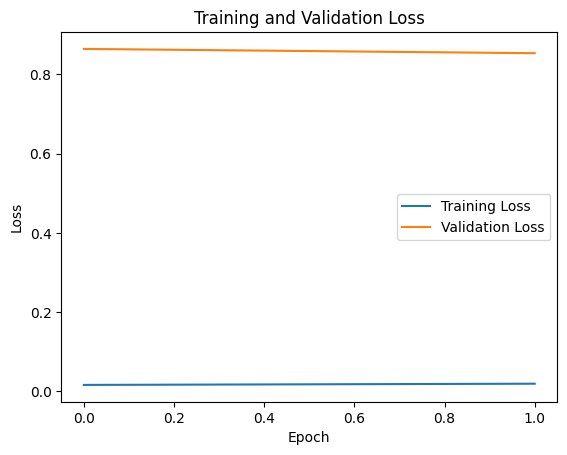

In [ ]:
# epochs = range(1, len(train_losses) + 1)  # Epochs for train_losses
# val_epochs = range(5, len(train_losses) + 1, 5)  # Epochs for val_losses (every 5th epoch)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v14(Inception)/my4.pth'

torch.save(my.state_dict(), model_path)


In [ ]:
my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 0.853189, Accuracy: 0.843650


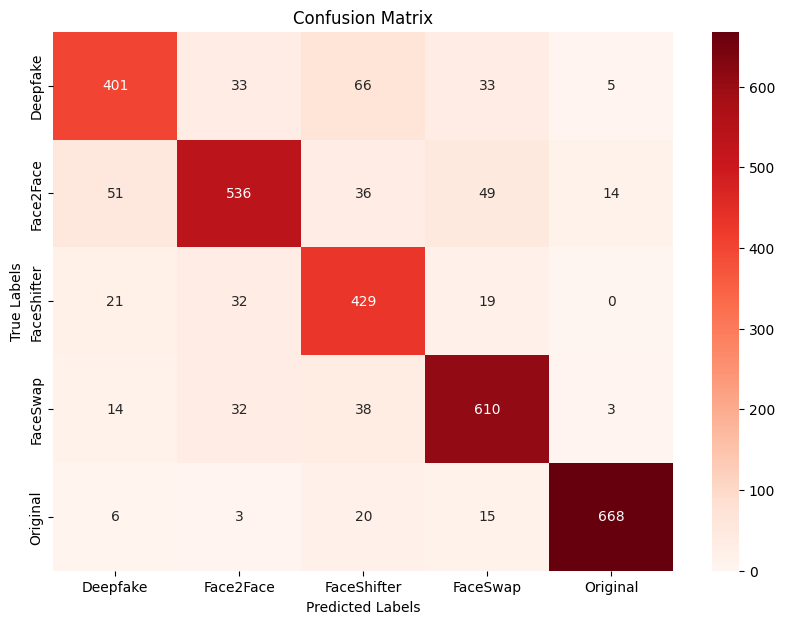

In [ ]:
conf_matrix = np.zeros((5, 5), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix[all_labels[i]][all_pred[i]] += 1

# print(conf_matrix)

# Data for the confusion matrix
confusion_matrix_data = conf_matrix

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()


# Testing

In [ ]:
my = inception_net_norm()

model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v14(Inception)/my.pth'
# Load saved model parameters into the model
my.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 0.657142, Accuracy: 0.855137


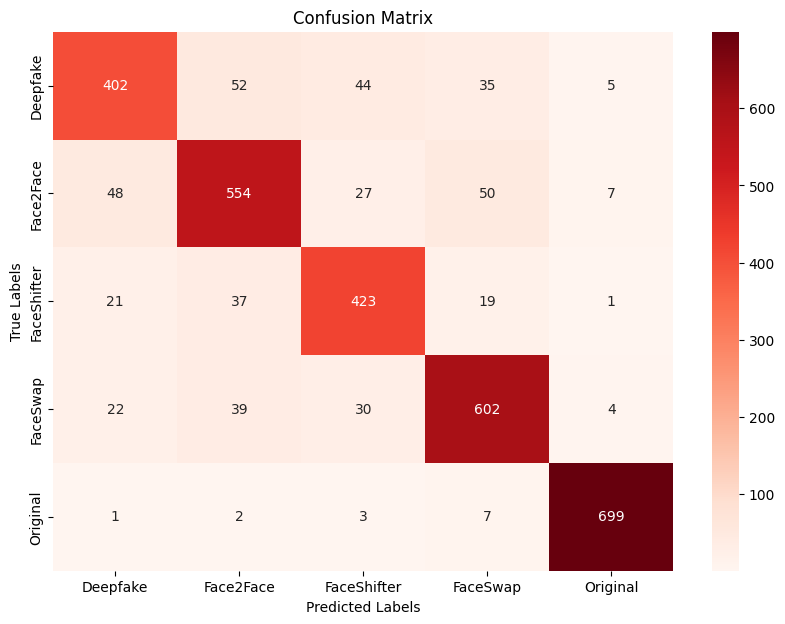

In [ ]:
conf_matrix = np.zeros((5, 5), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix[all_labels[i]][all_pred[i]] += 1

# print(conf_matrix)

# Data for the confusion matrix
confusion_matrix_data = conf_matrix

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()


0  =  Deepfakes

1  =  Face2Face

2  =  FaceShifter

3  =  FaceSwap

4  =  NeuralTextures

5  =  og_videos

*   Deepfake: 0.951
*   Face2Face: 0.952
*   FaceShifter: 0.971
*   FaceSwap: 0.964
*   Original: 0.989







In [ ]:
my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in train_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 0.031436, Accuracy: 0.997063


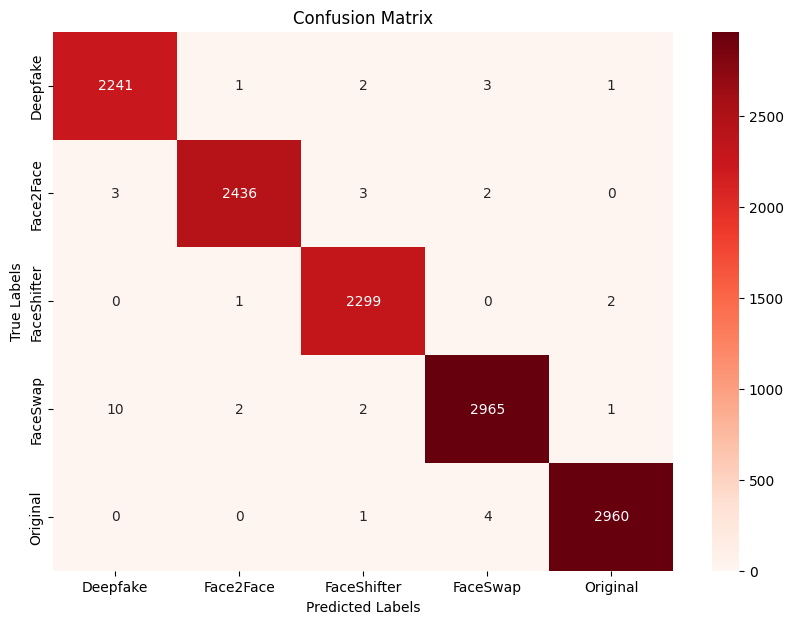

In [ ]:
conf_matrix = np.zeros((5, 5), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix[all_labels[i]][all_pred[i]] += 1

# print(conf_matrix)

# Data for the confusion matrix
confusion_matrix_data = conf_matrix

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()
